In [1]:
from pathlib import Path
datapath = Path("../data/wdc-v5")

# Get filtering stats

In [11]:
import json
import subprocess

all_statistics = {}
for path in datapath.glob("**/index.txt"):
    slice_id = path.parent.stem
    # print(slice_id)
    with open(path) as f:
        proc = subprocess.Popen(['tail', '-n', "20", path], stdout=subprocess.PIPE)
        lines = [line.decode("utf-8") for line in proc.stdout.readlines()]
    stats_labels = [
        "tables_initial",
        "tables_rejected_minrows",
        "tables_rejected_proseness",
        "tables_remaining",
        "tasks_initial",
        "tasks_rejected_maxdomain",
        "tasks_rejected_taskminrows",
        "tasks_rejected_onetomany",
        "tasks_rejected_minclasses",
        "tasks_rejected_taskminrows",
        "tasks_rejected_outputproseness",
        "tasks_rejected_classbalance",
        "tasks_remaining",
    ]
    stats = {}
    for line in lines:
        line_words = line.split()
        if len(line_words) != 2:
            continue
        key, val = line_words
        if key in stats_labels and val.isdigit:
            stats[key] = int(val)
    # print(stats)
    all_statistics[slice_id] = stats

aggregate_stats = {}
for slice_id, stats in all_statistics.items():
    assert stats.keys() == all_statistics[list(all_statistics)[0]].keys()
    for key, val in stats.items():
        if key not in aggregate_stats:
            aggregate_stats[key] = 0
        aggregate_stats[key] += val

for key, val in aggregate_stats.items():
    print(f"{key}: {val:,}")


tables_initial: 50,820,216
tables_rejected_minrows: 25,638,244
tables_rejected_proseness: 23,034,542
tables_remaining: 2,147,532
tasks_initial: 5,646,845
tasks_rejected_maxdomain: 4,054,764
tasks_rejected_taskminrows: 99,226
tasks_rejected_onetomany: 322,536
tasks_rejected_minclasses: 157,199
tasks_rejected_outputproseness: 561,622
tasks_rejected_classbalance: 38,505
tasks_remaining: 413,350


# Check pay-level domain distribution of filtered docs

In [3]:
import json
from itertools import islice
from urllib.parse import urlparse
from collections import Counter
from tqdm import tqdm

domain_counts = Counter()
for path in tqdm(islice(datapath.glob("**/*.jsonl"), 10000)):
    with open(path) as f:
        line = f.readline()
        obj = json.loads(line)
        domain = urlparse(obj['url']).netloc
        if domain.startswith('www.'):
            domain = domain[len('www.'):]
        # print(domain)
        domain_counts[domain] += 1

10000it [02:44, 60.80it/s]


[('football.fantasysports.yahoo.com', 68), ('naturalsciences.org', 65), ('acparadise.com', 65), ('carfax.com', 65), ('cosplayisland.co.uk', 65), ('cram.com', 65), ('technet.microsoft.com', 65), ('cisco.com', 64), ('kboo.org', 64), ('rockbox.org', 64), ('faqs.org', 64), ('getfirebug.com', 64), ('cpants.cpanauthors.org', 64), ('en.wikipedia.org', 64), ('docs.couchbase.com', 63), ('docs.joomla.org', 63), ('studystack.com', 63), ('gamefaqs.com', 62), ('homedepot.com', 62), ('socialexplorer.com', 62), ('phonearena.com', 62), ('twistedmatrix.com', 62), ('msdn.microsoft.com', 62), ('pof.com', 61), ('wiki.eclipse.org', 61), ('gicl.cs.drexel.edu', 61), ('baseball.fantasysports.yahoo.com', 61), ('cappex.com', 61), ('noisebridge.net', 61), ('techbase.kde.org', 60)]
1893
10000
2018
8107


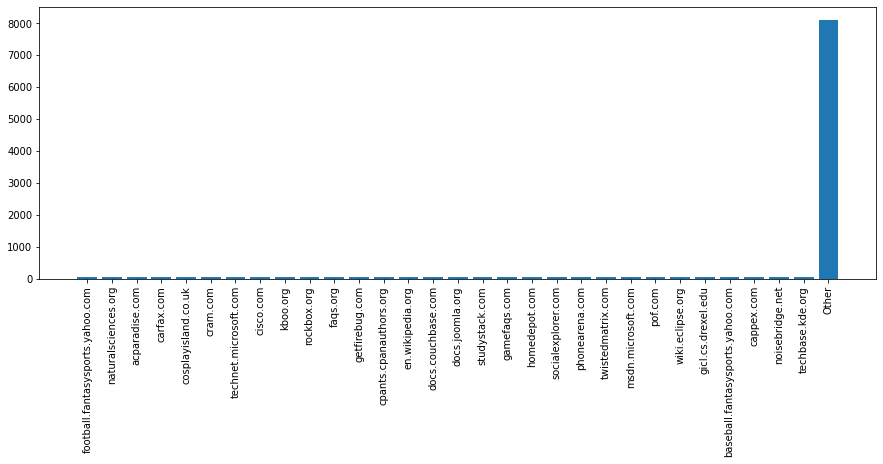

In [4]:
import matplotlib.pyplot as plt


top_domains_counts = domain_counts.most_common(30)
top_domains_total = sum([count for domain, count in top_domains_counts])
total_domains = len(domain_counts.keys())
total_count = sum(domain_counts.values())
remaining_count = total_count - top_domains_total

print(top_domains_counts)
print(top_domains_total)
print(total_count)
print(total_domains)
print(remaining_count)

xx, yy = zip(*top_domains_counts)
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(list(xx) + ["Other"], list(yy) + [remaining_count])
ax.tick_params(axis='x', labelrotation=90)
fig.show()


In [5]:
print(f"{top_domains_counts[0][0]} accounts for {top_domains_counts[0][1] / total_count * 100}% of total content.")

football.fantasysports.yahoo.com accounts for 0.6799999999999999% of total content.


(0.0, 71.35)

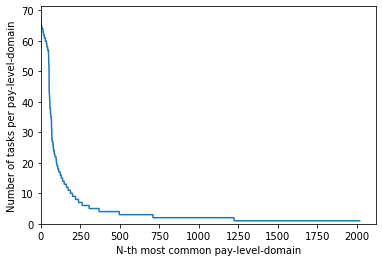

In [10]:
plt.plot(range(len(domain_counts)), sorted(domain_counts.values(), reverse=True))
plt.ylabel("Number of tasks per pay-level-domain")
plt.xlabel("N-th most common pay-level-domain")
plt.xlim(left=0)
plt.ylim(bottom=0)

## Peek at rare domain tables

In [14]:
import json
from itertools import islice
from urllib.parse import urlparse
from collections import Counter
from tqdm import tqdm

with open('tmp.txt', 'w') as f_debug:

    domain_counts = Counter()
    for idx, path in tqdm(enumerate(islice(datapath.glob("**/*.jsonl"), 1500))):
        with open(path) as f:
            lines = f.readlines()
            obj = json.loads(lines[0])
            domain = urlparse(obj['url']).netloc
            if domain.startswith('www.'):
                domain = domain[len('www.'):]
            if idx > 1000 and domain_counts[domain] < 1:
                print(domain, file=f_debug)
                for line in lines:
                    obj = json.loads(line)
                    print("INPUT   :", obj['input'], file=f_debug)
                    print("OPTIONS :", obj['options'], file=f_debug)
                    print("OUTPUT  :", obj['output'], file=f_debug)
                    print("---", file=f_debug)
                print("", file=f_debug)
            domain_counts[domain] += 1

1500it [00:05, 259.09it/s]
